In [1]:
import torch
import torch.nn.utils.prune as prune
from transformers import GPT2Model, BertForSequenceClassification, BartForConditionalGeneration, BertModel, BartModel, PegasusModel

/home/mtynes/.conda/envs/hfsource/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import OrderedDict

In [4]:
gpt2 = GPT2Model.from_pretrained('gpt2')

In [5]:
bert = BertModel.from_pretrained('bert-base-uncased')
bart = BartModel.from_pretrained("facebook/bart-large", forced_bos_token_id=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
pegasus = PegasusModel.from_pretrained("google/pegasus-large")

Some weights of the model checkpoint at google/pegasus-large were not used when initializing PegasusModel: ['final_logits_bias']
- This IS expected if you are initializing PegasusModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PegasusModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
models = OrderedDict({'bert': bert, 
                      'gpt-2': gpt2, 
                      #'bart': bart,
                      'pegasus': pegasus
                     })

In [8]:
def get_parameters(model): 
    return torch.cat([p.flatten() for p in model.parameters()]).detach().numpy()

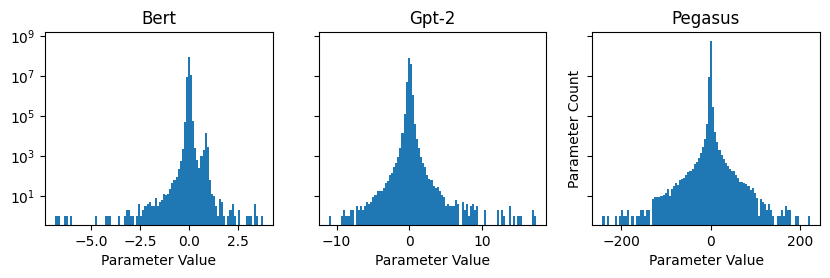

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,2.5), sharex=False, sharey=True)
for i, (modelname, model) in enumerate(models.items()): 
    if i == 0: 
        plt.ylabel('Parameter Count')
    weights = get_parameters(model)
    plt.sca(ax[i])
    plt.hist(weights, bins=100);
    plt.yscale('log')
    plt.xlabel('Parameter Value')
    plt.title(modelname.capitalize())

In [10]:
def get_frac_lt_order(parameters):
    """for a set of powers of 10, find the fraction of weights greater"""
    thresholds = np.linspace(1, -5, 100)
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = np.count_nonzero(np.abs(parameters) < np.power(10., thresholds[i]))
    return thresholds, counts/parameters.shape[0]

bert
n_params: 109,482,240
frac < 0.1:  0.98
gpt-2
n_params: 124,439,808
frac < 0.1:  0.59
pegasus
n_params: 570,797,056
frac < 0.1:  0.23


Text(0, 0.5, 'Frac Weights < Threshhold')

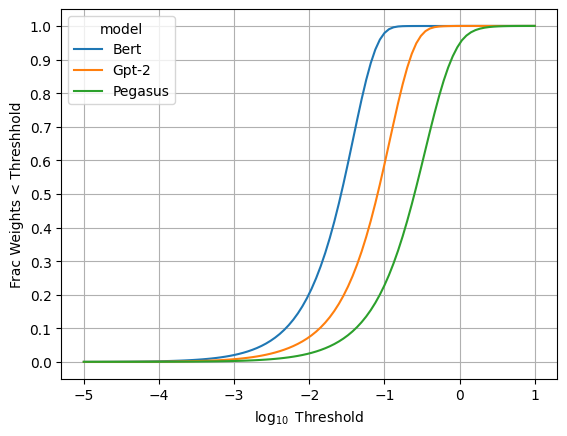

In [11]:
for i, (modelname, model) in enumerate(models.items()): 
    print(modelname)
    weights = get_parameters(model)
    thresh, frac = get_frac_lt_order(weights)
    print(f'n_params: {weights.shape[0]:,}')
    print(f'frac < 0.1: {frac[np.where(thresh == -1)][0]: 0.2f}')
    plt.plot(thresh, frac, label=modelname.capitalize())
plt.grid('on')
plt.legend(title='model');
plt.yticks(np.linspace(0, 1, 11));
#plt.xticks(np.linspace(-10, 1, 12));
plt.xlabel('$\log_{10}$ Threshold')
plt.ylabel('Frac Weights < Threshhold')

In [12]:
models_ = OrderedDict({'bert': bert, 
                       'gpt-2': gpt2, 
                       #'bart_E': bart.get_encoder(), 
                       #'bart_D': bart.get_decoder()
                       'pegasus_E': pegasus.get_encoder(), 
                       'pegasus_D': pegasus.get_decoder(),
                      })

In [13]:
sparsities_by_layer = []

for modelname, model in models_.items():
    print(modelname)
    for i, layer in enumerate(gpt2.h): 
        weights = get_parameters(layer)
        thresh, frac = get_frac_lt_order(weights)
        result = pd.DataFrame({'thresh': thresh, 'frac': frac})
        result['layer'] = i
        result['model'] = modelname
        sparsities_by_layer.append(result)
sparsities_by_layer = pd.concat(sparsities_by_layer)

bert
gpt-2
pegasus_E
pegasus_D


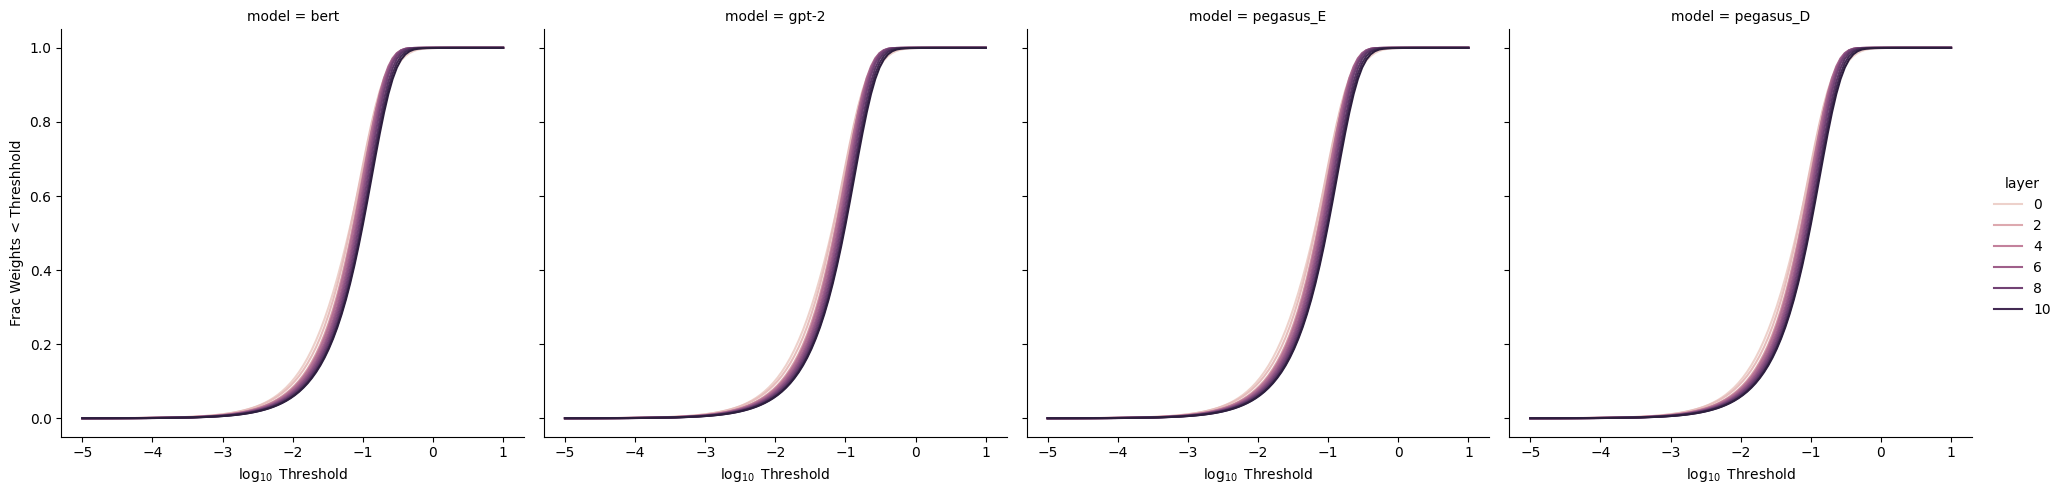

In [14]:
g = sns.relplot(col='model', 
            x='thresh', 
            y='frac', 
            hue='layer', 
            kind='line', 
            data=sparsities_by_layer)
g.set_xlabels('$\log_{10}$ Threshold')
g.set_ylabels('Frac Weights < Threshhold')

In [15]:
def flatten(m):
    f = [x for c in m.children() for x in flatten(c)]
    if len(f) == 0:
        return [m]
    else:
        return f

In [16]:
def prune_model(model, amount):
    
    layers = flatten(model)
    params_to_prune = [(m, p[0]) for m in layers for p in m.named_parameters() if p[0][-6:] == "weight"]
    #print(params_to_prune)

    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    for (m, name) in params_to_prune:
        try:
            prune.remove(m, name)
        except Exception as e:
            print(e)

    return model

In [17]:
models.keys()

odict_keys(['bert', 'gpt-2', 'pegasus'])

In [18]:
del models['pegasus']

In [19]:
models.keys()

odict_keys(['bert', 'gpt-2'])

In [20]:
model_dir = '../transformers/examples/pytorch/language-modeling/models'
amounts = [0, .1, .5, .9, .95, .99]
for modelname, model in tqdm(models.items(), 'model'):
    for amount in tqdm(amounts, 'amounts'): 
        pruned_model = prune_model(model, amount) if amount > 0 else model
        pruned_name = f'{modelname}-{amount}'
        model.save_pretrained(f'{model_dir}/{pruned_name}')

model: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.63s/it]


In [12]:
import json
from glob import glob 

In [13]:
import os
import re

In [14]:
result_dirs = [f for f in glob('../transformers/examples/pytorch/language-modeling/*results*') if 'train' not in f]
model_results = []

for result_dir in result_dirs: 
    sparsity = re.search('([0-9\.]+)$', result_dir).group(1)
    model = 'gpt2' if 'gpt' in result_dir else 'bert'
    with open(os.path.join(result_dir, 'all_results.json'), 'r') as f: 
        result = json.load(f)
    result = pd.DataFrame([result])
    result['model'] = model
    result['sparsity'] = float(sparsity)
    model_results.append(result)
model_results = pd.concat(model_results).reset_index(drop=True)

In [15]:
model_results

,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second,perplexity,model,sparsity
0,0.000000,10.589485,6.5153,479,73.520,2.302,39715.037308,bert,0.00
1,0.019192,8.989132,7.0152,240,34.211,1.140,8015.495843,gpt2,0.50
2,0.000000,10.589485,6.5112,479,73.566,2.304,39715.037308,bert,0.10
3,0.379057,3.422000,7.0891,240,33.855,1.129,30.630606,gpt2,0.00
4,0.029562,8.831075,7.0507,240,34.039,1.135,6843.637823,gpt2,0.95
5,0.000000,10.589485,6.5313,479,73.339,2.297,39715.037308,bert,0.50
6,0.000000,10.589485,6.5968,479,72.611,2.274,39715.037308,bert,0.95
7,0.000000,10.589485,6.5482,479,73.150,2.291,39715.037308,bert,0.99
8,0.000000,10.589485,6.5447,479,73.189,2.292,39715.037308,bert,0.90
9,0.041549,9.653749,7.0478,240,34.053,1.135,15580.080905,gpt2,0.99


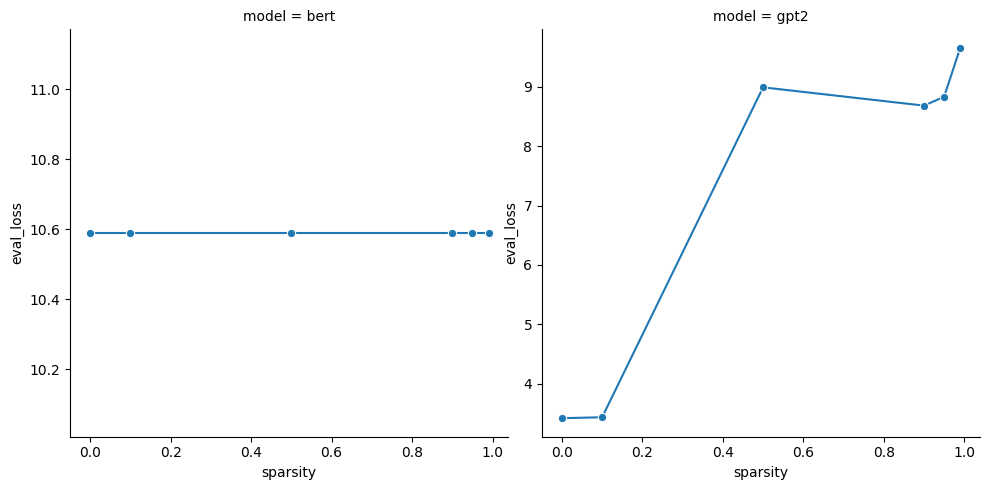

In [16]:
sns.relplot(col='model', 
             x='sparsity',
             y='eval_loss',
             data=model_results,
            kind='line', 
            marker='o',
            facet_kws=dict(sharey=False),
            )

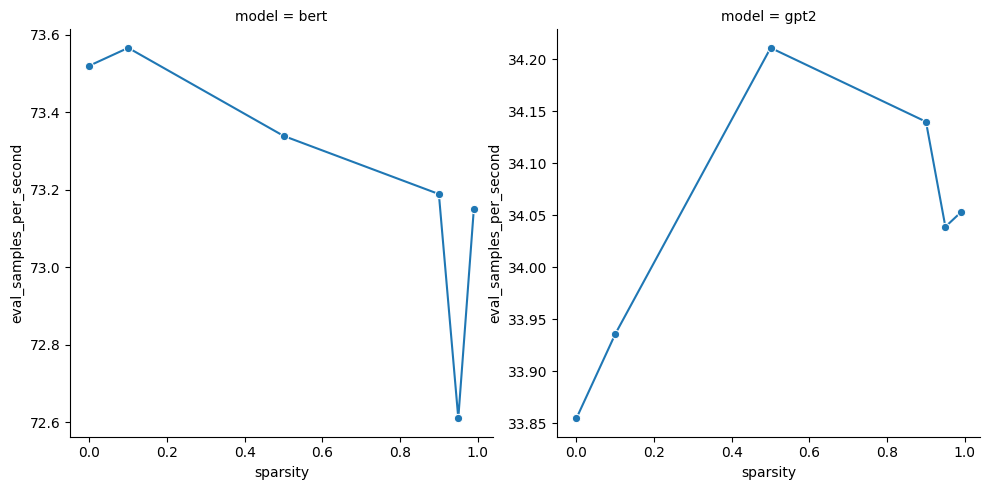

In [17]:
sns.relplot(col='model', 
             x='sparsity',
             y='eval_samples_per_second',
             data=model_results,
            kind='line', 
            marker='o',
            facet_kws=dict(sharey=False),
            )

In [26]:
result_dirs = [f for f in glob('../transformers/examples/pytorch/language-modeling/*results*') if 'train' in f]
model_results = []

for result_dir in result_dirs: 
    sparsity = re.search('([0-9\.]+)$', result_dir).group(1)
    model = 'gpt2' if 'gpt' in result_dir else 'bert'
    try:
        with open(os.path.join(result_dir, 'all_results.json'), 'r') as f: 
            result = json.load(f)
    except: 
        pass
    else:
        result = pd.DataFrame([result])
        result['model'] = model
        result['sparsity'] = float(sparsity)
        model_results.append(result)
model_results = pd.concat(model_results).reset_index(drop=True)

<AxesSubplot: xlabel='sparsity', ylabel='eval_loss'>

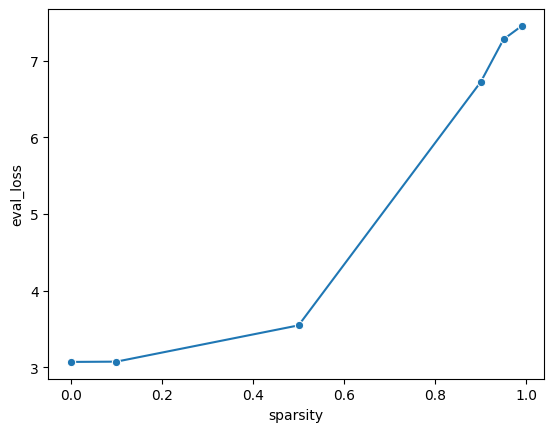

<AxesSubplot: xlabel='sparsity', ylabel='eval_samples_per_second'>

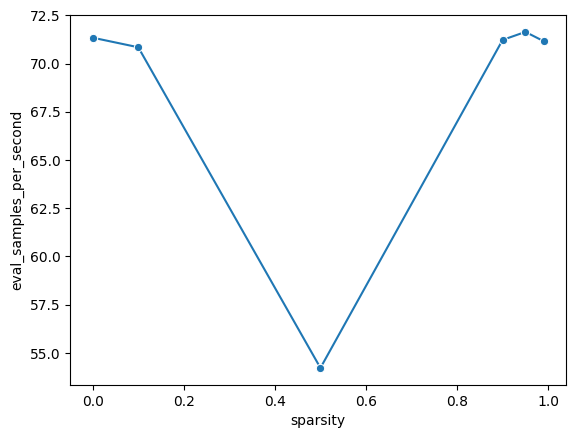

In [30]:
sns.lineplot(
             x='sparsity',
             y='eval_samples_per_second',
             data=model_results,
             marker='o')